# Exploring trained stage 1 reconstruction of different spectrograms.

In [2]:
# Setup
import sys
from pathlib import Path

import torch

_cwd = Path(".").resolve()
PROJECT_ROOT = _cwd.parent if _cwd.name == "notebooks" else _cwd
sys.path.insert(0, str(PROJECT_ROOT))

CKPT_DIR = PROJECT_ROOT / "checkpoints"
DATA_PATH = "/mnt/ssd/LaCie/dcase2020-task2-dev-dataset"  # set to your DCASE root
MACHINE_TYPE = ["fan", "pump", "slider", "ToyCar", "ToyConveyor", "valve"]
STAGE1_CKPT = CKPT_DIR / "stage1/fan/stage1_ToyCar+ToyConveyor+fan+pump+slider+valve_final.pt"  # or stage1_{machine_type}_iter_*.pt


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Load a random sample per machine_id and machine type
from src.data.dataset import DCASE2020Task2LogMelDataset

normal_plot_dict = {}

for machine_type in MACHINE_TYPE:
    normal_plot_dict[machine_type] = {}
    dataset = DCASE2020Task2LogMelDataset(
        root=DATA_PATH,
        machine_type=machine_type,
        normalize=True,
    )
    for i in range(len(dataset)):
        machine_id = dataset._machine_id_strs[i]
        if machine_id not in normal_plot_dict[machine_type]:
            normal_plot_dict[machine_type][machine_id] = dataset[i][0]
            if len(normal_plot_dict[machine_type]) == len(dataset.machine_ids):
                break

Padded T: 313 → 320 (target: 320)
DCASE2020Task2LogMelDataset: fan | 3675 spectrograms, shape (3675, 1, 128, 320) | IDs: ['id_00', 'id_02', 'id_04', 'id_06'] | 0.60 GB in RAM
Padded T: 313 → 320 (target: 320)
DCASE2020Task2LogMelDataset: pump | 3349 spectrograms, shape (3349, 1, 128, 320) | IDs: ['id_00', 'id_02', 'id_04', 'id_06'] | 0.55 GB in RAM
Padded T: 313 → 320 (target: 320)
DCASE2020Task2LogMelDataset: slider | 2804 spectrograms, shape (2804, 1, 128, 320) | IDs: ['id_00', 'id_02', 'id_04', 'id_06'] | 0.46 GB in RAM
Padded T: 344 → 352 (target: 352)
DCASE2020Task2LogMelDataset: ToyCar | 4000 spectrograms, shape (4000, 1, 128, 352) | IDs: ['id_01', 'id_02', 'id_03', 'id_04'] | 0.72 GB in RAM
Padded T: 313 → 320 (target: 320)
DCASE2020Task2LogMelDataset: ToyConveyor | 3000 spectrograms, shape (3000, 1, 128, 320) | IDs: ['id_01', 'id_02', 'id_03'] | 0.49 GB in RAM
Padded T: 313 → 320 (target: 320)
DCASE2020Task2LogMelDataset: valve | 3291 spectrograms, shape (3291, 1, 128, 320) | I

In [4]:
from src.models.vq_vae.autoencoders import VQ_VAE_2Layer

n_mels = 128
T = 320

def build_vq_vae(n_mels: int, T: int) -> VQ_VAE_2Layer:
    return VQ_VAE_2Layer(
        num_hiddens=128,
        num_residual_layers=2,
        num_residual_hiddens=64,
        num_embeddings=(4096, 4096),
        embedding_dim=128,
        commitment_cost=0.25,
        decay=0.99,
    )

vq_vae = build_vq_vae(n_mels, T)
if STAGE1_CKPT.exists():
    ckpt = torch.load(STAGE1_CKPT, map_location="cpu", weights_only=False)
    vq_vae.load_state_dict(ckpt["model_state_dict"])
    print(f"Loaded checkpoint: {STAGE1_CKPT}")
else:
    print("Warning: Stage1 checkpoint not found; using random weights.")
vq_vae = vq_vae.to(DEVICE)
vq_vae.eval()

# Feed normal samples to stage 1 model
normal_reconstructions_dict = {}
for machine_type in MACHINE_TYPE:
    normal_reconstructions_dict[machine_type] = {}
    for machine_id in normal_plot_dict[machine_type]:
        x = normal_plot_dict[machine_type][machine_id]
        x = x.unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            _, _, recon_x, _, _, _, _ = vq_vae.forward(x)
            normal_reconstructions_dict[machine_type][machine_id] = recon_x

Loaded checkpoint: /home/lucash/Documents/NTUST/Research/papers/semantic-communication-networks/audDSR/checkpoints/stage1/fan/stage1_ToyCar+ToyConveyor+fan+pump+slider+valve_final.pt


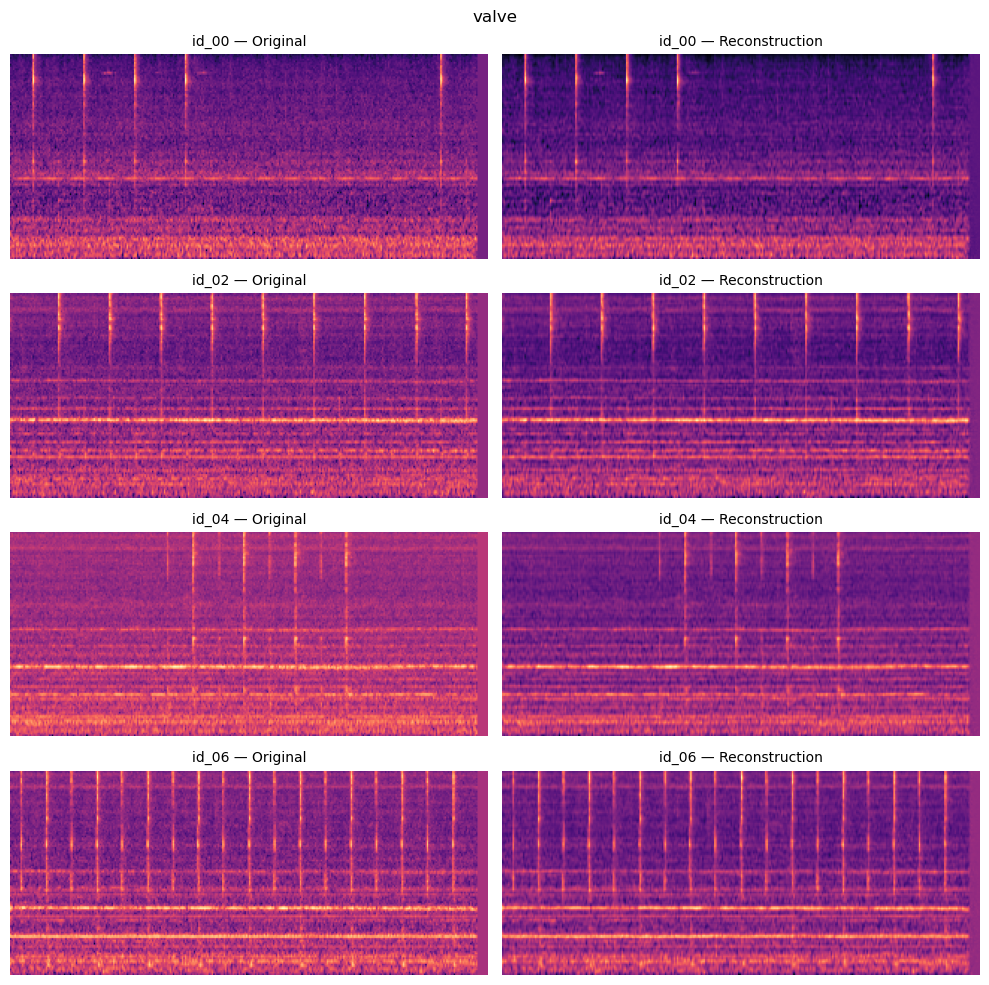

In [ ]:
# One figure per machine type: each row = one machine_id (original | reconstructed)
import matplotlib.pyplot as plt

ids = sorted(normal_plot_dict[machine_type].keys())
n_rows = len(ids)
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 2.25 * n_rows))
fig.suptitle(machine_type, fontsize=12)
if n_rows == 1:
    axes = axes.reshape(1, -1)
for row, machine_id in enumerate(ids):
    orig = normal_plot_dict[machine_type][machine_id].squeeze().cpu().numpy()
    recon = normal_reconstructions_dict[machine_type][machine_id].squeeze().cpu().numpy()
    axes[row, 0].imshow(orig, aspect='auto', origin='lower', cmap='magma')
    axes[row, 0].set_title(f'{machine_id} — Original', fontsize=10)
    axes[row, 0].axis('off')
    axes[row, 1].imshow(recon, aspect='auto', origin='lower', cmap='magma')
    axes[row, 1].set_title(f'{machine_id} — Reconstruction', fontsize=10)
    axes[row, 1].axis('off')
plt.tight_layout()
plt.show()